In [1]:
import warnings
with warnings.catch_warnings():
    warnings.simplefilter(action='ignore', category=FutureWarning)

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import Markdown
from scipy import signal
import numpy as np
import sys

In [2]:
sys.path.insert(1,'../data')
train_events = pd.read_csv("../data/train_events.csv")
train_series = pd.read_parquet("../data/train_series.parquet")
train_events.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14510 entries, 0 to 14509
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   series_id  14510 non-null  object 
 1   night      14510 non-null  int64  
 2   event      14510 non-null  object 
 3   step       9587 non-null   float64
 4   timestamp  9587 non-null   object 
dtypes: float64(1), int64(1), object(3)
memory usage: 566.9+ KB


In [3]:
series_has_NaN = train_events.groupby('series_id')['step'].apply(lambda x: x.isnull().any())
series_has_NaN.value_counts()
df_has_NaN = series_has_NaN.to_frame()
df_has_NaN.reset_index(inplace=True)
notNaN = df_has_NaN.loc[df_has_NaN.step == False]["series_id"].to_list()
print(f"Number of series that do not contain NaN values: {len(notNaN)}, {notNaN}")

Number of series that do not contain NaN values: 37, ['08db4255286f', '0a96f4993bd7', '0cfc06c129cc', '1087d7b0ff2e', '10f8bc1f7b07', '18b61dd5aae8', '29c75c018220', '31011ade7c0a', '3452b878e596', '349c5562ee2c', '3664fe9233f9', '483d6545417f', '55a47ff9dc8a', '5acc9d63b5fd', '5f94bb3e1bed', '655f19eabf1e', '67f5fc60e494', '72bbd1ac3edf', '76237b9406d5', '7822ee8fe3ec', '89bd631d1769', '8e32047cbc1f', '939932f1822d', '9ee455e4770d', 'a596ad0b82aa', 'a9a2f7fac455', 'a9e5f5314bcb', 'af91d9a50547', 'b364205aba43', 'c535634d7dcd', 'c6788e579967', 'c68260cc9e8f', 'ca730dbf521d', 'd150801f3145', 'd25e479ecbb7', 'd515236bdeec', 'd5e47b94477e']


In [4]:
train_events = train_events.dropna()

In [5]:
def get_train_series(train_series, train_events, series):
    current_series = train_series[train_series["series_id"] == series]
    current_events = train_events[train_events["series_id"] == series]

    # cleaning etc.
    current_events = current_events.dropna()
    current_events["step"] = current_events["step"].astype("int")
    current_events["awake"] = current_events["event"].replace({"onset": 1, "wakeup": 0})

    train = pd.merge(current_series, current_events[['step', 'awake']], on='step', how='left')
    train["awake"] = train["awake"].bfill(axis='rows')
    # final section:
    # train_events.groupby('series_id').tail(1)["event"].unique()
    # Result: the last event is always a "wakeup"
    train['awake'] = train['awake'].fillna(1)  # awake
    train["awake"] = train["awake"].astype("int")
    return train

series_id     object
step          uint32
timestamp     object
anglez       float32
enmo         float32
awake          int32
dtype: object
(1, 50)


###  anglez for series 08db4255286f

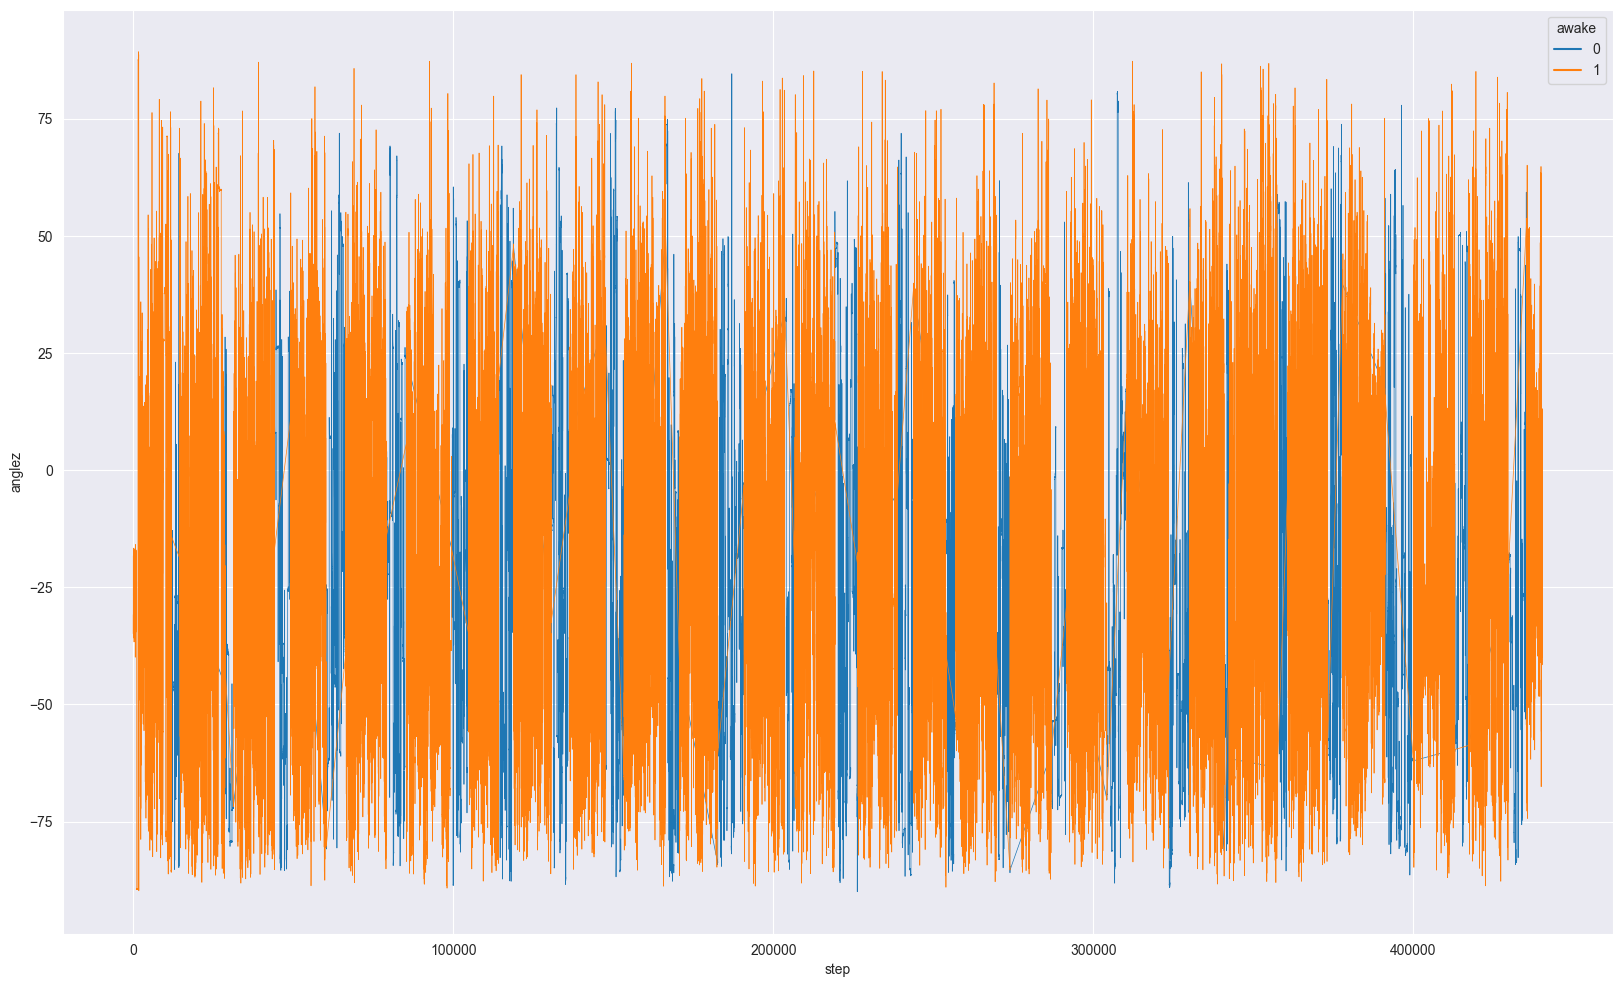

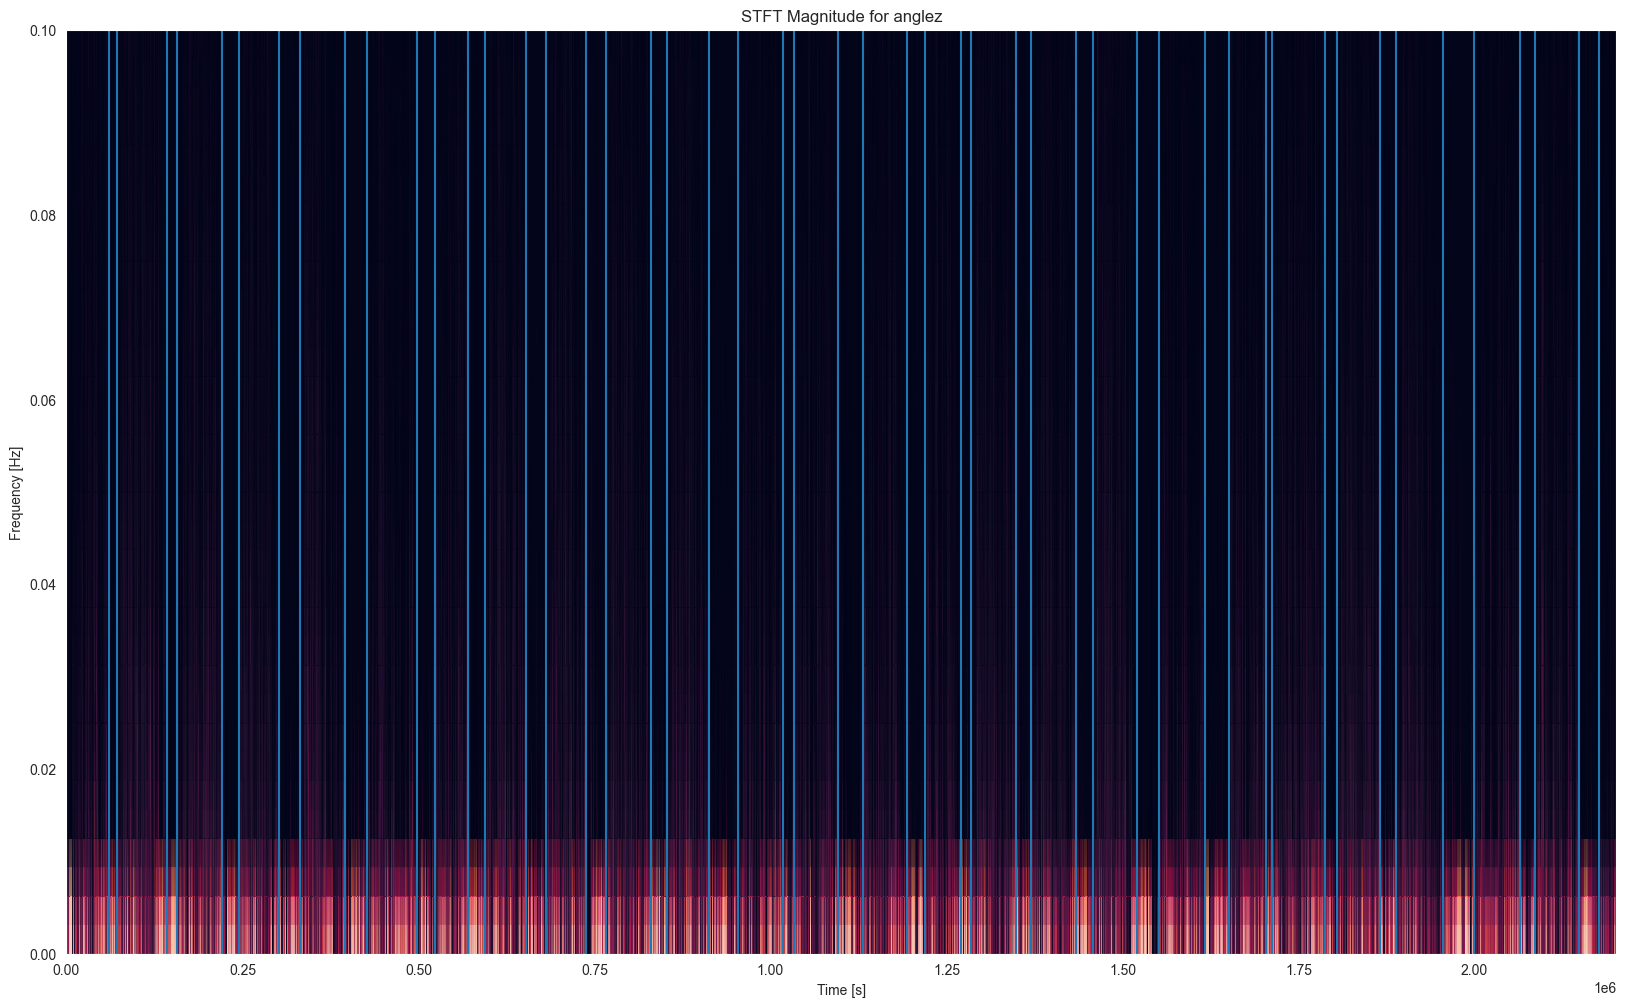

###  enmo for series 08db4255286f

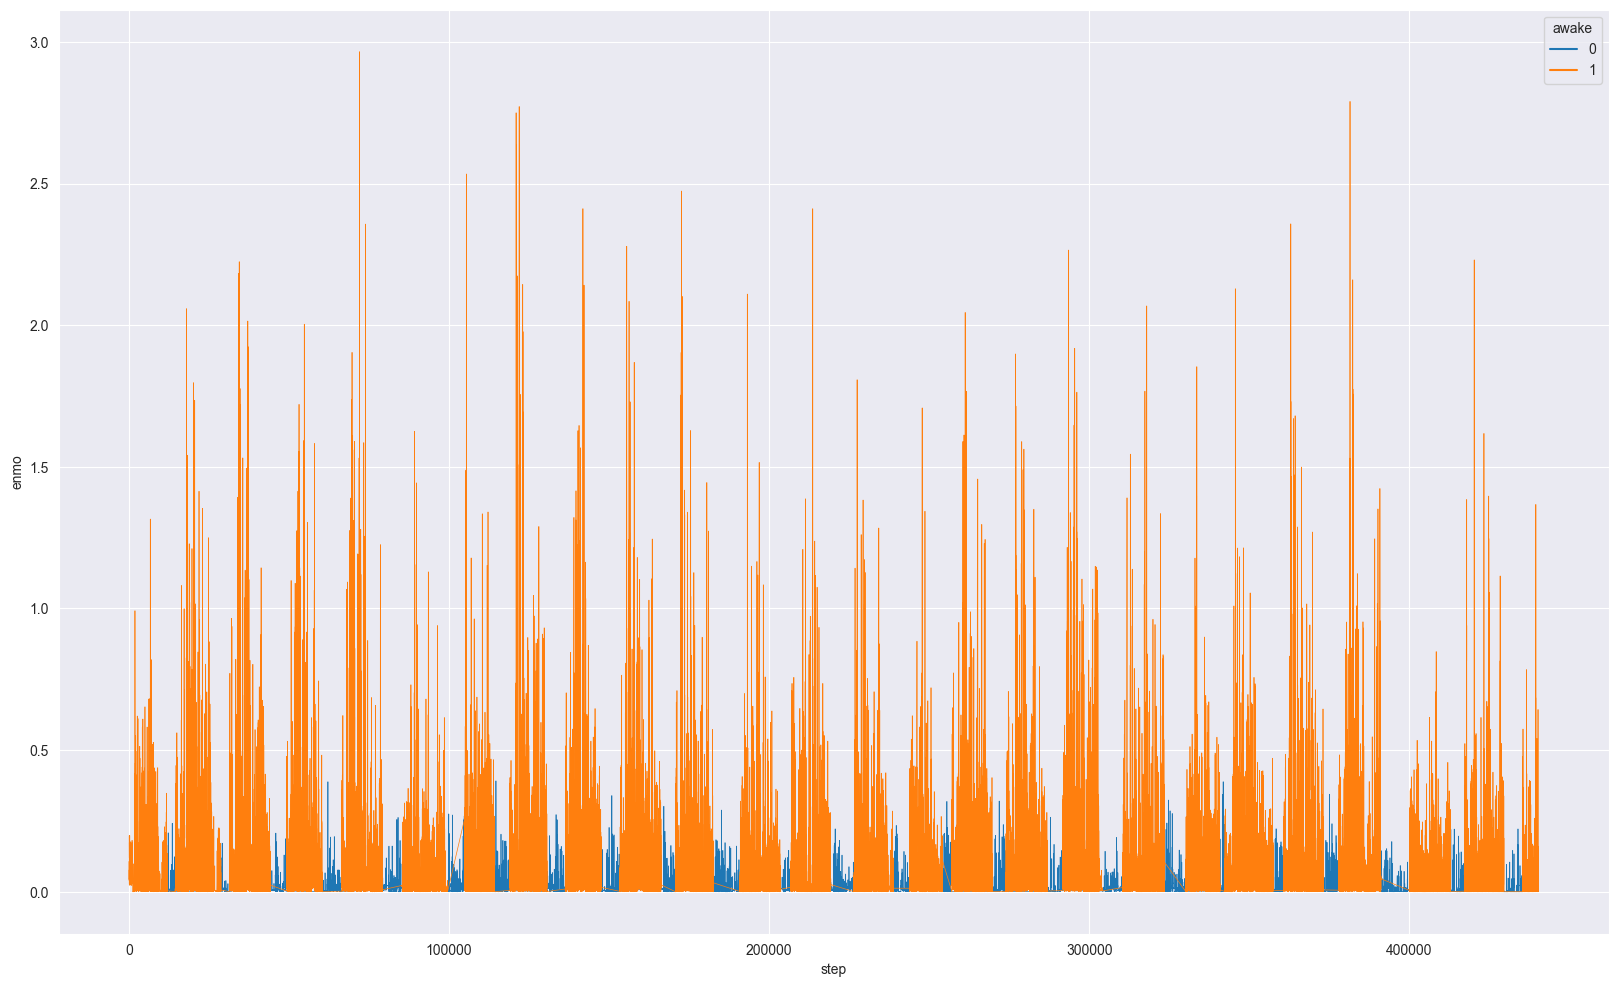

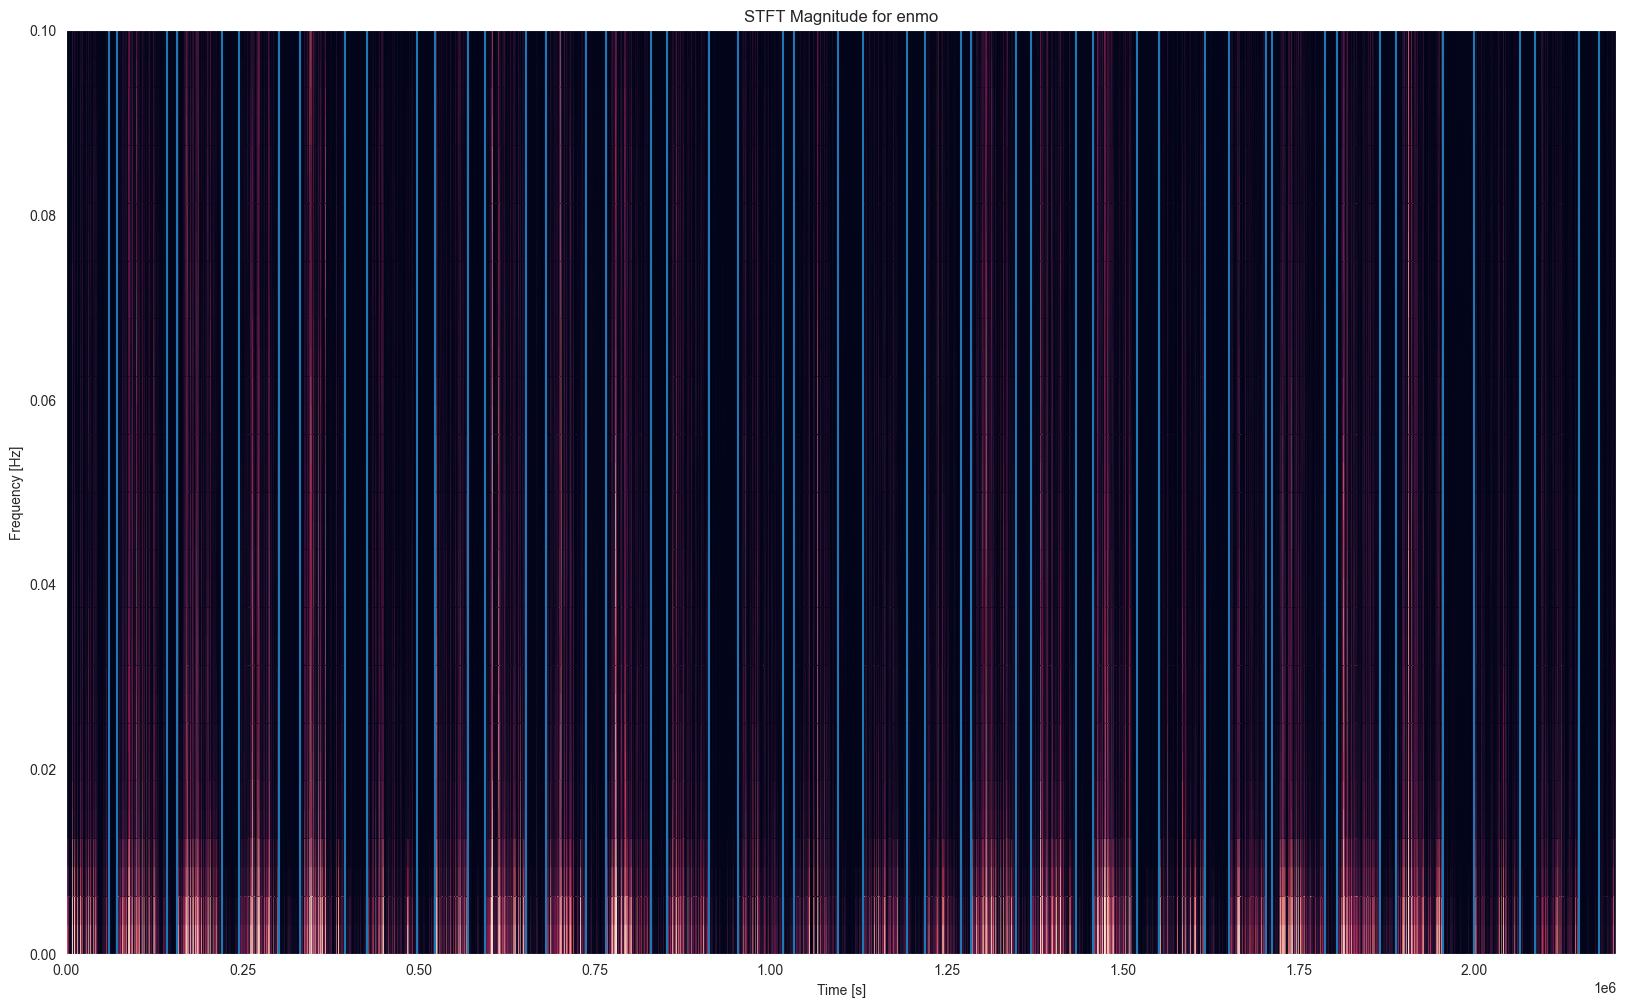

In [6]:
clean_train_data = []
import sys
sys.path.insert(1,'../src')
from spectogram import spectogram

for series_id in notNaN[:1]:
    train = get_train_series(train_series, train_events, series_id)
    print(train.dtypes)
    clean_train_data.append(train)

    # get the indices of when a state transition occurs to visualize in the stft plots
    #display(train['awake'])
    diffs = np.diff(train['awake'])
    idxs = np.where(np.abs(diffs) == 1)
    print(np.shape(idxs))
    # the timestamps are 5 seconds per step
    timestamps = np.multiply(idxs, [5])
    # separate the anglez and enmo values for later
    anglez = train['anglez']
    enmo = train['enmo']
    # use stft from scipy to generate fft over time curve
    # Important: To be able to use fft and stft we need to know the sampling freq.
    # ie. frequency at which our data was collected. Since we get 1 sample every 5 seconds our
    # Fs = 0.2 Hz
    fs = 0.2

    # visualize anglez over steps
    display(Markdown('###  anglez for series ' + series_id))
    plt.figure(figsize=(20, 12))
    sns.lineplot(data=train, x="step", y="anglez",hue="awake", linewidth = 0.5)
    plt.show()

    # do stft on the anglez data
    f, t, Zxx = signal.stft(anglez.to_numpy(), fs, nperseg=32, scaling = 'psd')
    Y_abs = np.abs(Zxx)

    #plot the stft results for anglez
    plt.figure(figsize=(20, 12))
    #Set the max scale of the colormesh to mean+5*std otherwise outliers make the graph unreadable
    plt.pcolormesh(t, f, np.abs(Zxx),vmax=np.mean(Y_abs)+5*np.std(Y_abs),shading='gouraud')
    plt.vlines(timestamps, ymin=0, ymax = fs/2)
    plt.title('STFT Magnitude for anglez')
    plt.ylabel('Frequency [Hz]')
    plt.xlabel('Time [s]')
    plt.show()

    # display the enmo values over time
    display(Markdown('###  enmo for series ' + series_id))
    plt.figure(figsize=(20, 12))
    sns.lineplot(data=train, x="step", y="enmo",hue="awake", linewidth = 0.5)
    plt.show()

    # calculate the stft results for the enmo
    f, t, Zxx = signal.stft(enmo.to_numpy(), fs, nperseg=32, scaling = 'psd')
    Y_abs = np.abs(Zxx)
    #img = spectogram(plot = False, y = enmo.to_numpy(), fs = fs, nperseg = 256)
    #plt.imshow(img)

    #plot the stft results for the enmo
    plt.figure(figsize=(20, 12))
    #Set the max scale of the colormesh to mean+5*std otherwise outliers make the graph unreadable
    plt.pcolormesh(t, f, np.abs(Zxx),vmax=np.mean(Y_abs)+5*np.std(Y_abs),shading='gouraud')
    plt.vlines(timestamps, ymin=0, ymax = fs/2)
    plt.title('STFT Magnitude for enmo')
    plt.ylabel('Frequency [Hz]')
    plt.xlabel('Time [s]')

    del train

In [7]:
# This block is to experiment with hilbert transform

# does not look very useful so i commented it out

# clean_train_data = []
# import sys
# sys.path.insert(1,'../src')
#
# for series_id in notNaN[:1]:
#     train = get_train_series(train_series, train_events, series_id)
#     print(train.dtypes)
#     clean_train_data.append(train)
#
#     # get the indices of when a state transition occurs to visualize in the stft plots
#     #display(train['awake'])
#     diffs = np.diff(train['awake'])
#     idxs = np.where(np.abs(diffs) == 1)
#     print(np.shape(idxs))
#     # the timestamps are 5 seconds per step
#     timestamps = np.multiply(idxs, [5])
#     # separate the anglez and enmo values for later
#     anglez = train['anglez']
#     enmo = train['enmo']
#     # use stft from scipy to generate fft over time curve
#     # Important: To be able to use fft and stft we need to know the sampling freq.
#     # ie. frequency at which our data was collected. Since we get 1 sample every 5 seconds our
#     # Fs = 0.2 Hz
#     fs = 0.2
#
#     # starting with anglez
#     analytic_signal = hilbert(anglez)
#     amplitude_envelope = np.abs(analytic_signal)
#     instantaneous_phase = np.unwrap(np.angle(analytic_signal))
#     instantaneous_frequency = (np.diff(instantaneous_phase) /
#                                (2.0*np.pi) * fs)
#
#     t = np.multiply(np.arange(0,len(anglez)), 5)
#     plt.figure(figsize = (20,12))
#     sns.lineplot(data=train, x="step", y="anglez",hue="awake", linewidth = 0.5)
#     plt.plot(amplitude_envelope, c='g')
#     plt.vlines(timestamps/5, ymin=0, ymax = max(amplitude_envelope), colors = 'r')
#     plt.legend(['anglez', 'amplitude envelope', 'state changes'])
#
#     plt.show()
#
#     # now the same for the enmo
#     analytic_signal = hilbert(enmo)
#     amplitude_envelope = np.abs(analytic_signal)
#     instantaneous_phase = np.unwrap(np.angle(analytic_signal))
#     instantaneous_frequency = (np.diff(instantaneous_phase) /
#                                (2.0*np.pi) * fs)
#     plt.figure(figsize = (20,12))
#     sns.lineplot(data=train, x="step", y="enmo",hue="awake", linewidth = 0.5)
#     plt.plot(amplitude_envelope, c='g')
#     plt.vlines(timestamps/5, ymin=0, ymax = max(amplitude_envelope), colors = 'r')
#     plt.legend(['anglez', 'amplitude envelope', 'state changes'])
#     plt.show()
#
#     del train

series_id     object
step          uint32
timestamp     object
anglez       float32
enmo         float32
awake          int32
dtype: object
(1, 50)


###  anglez for series 08db4255286f

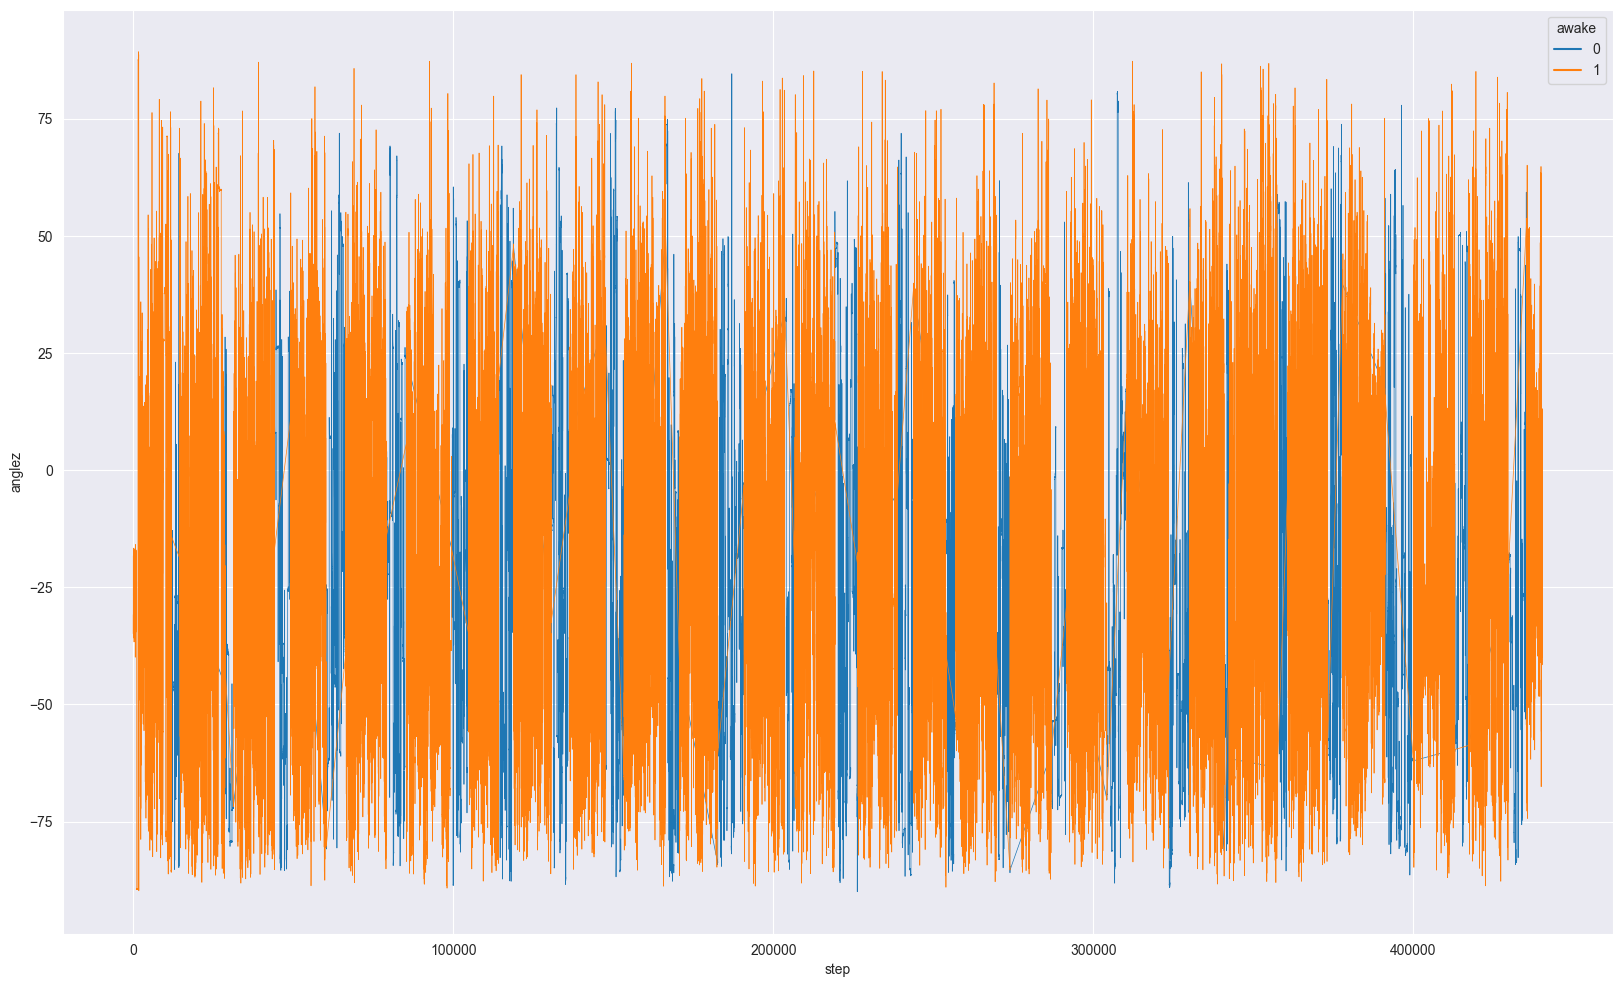

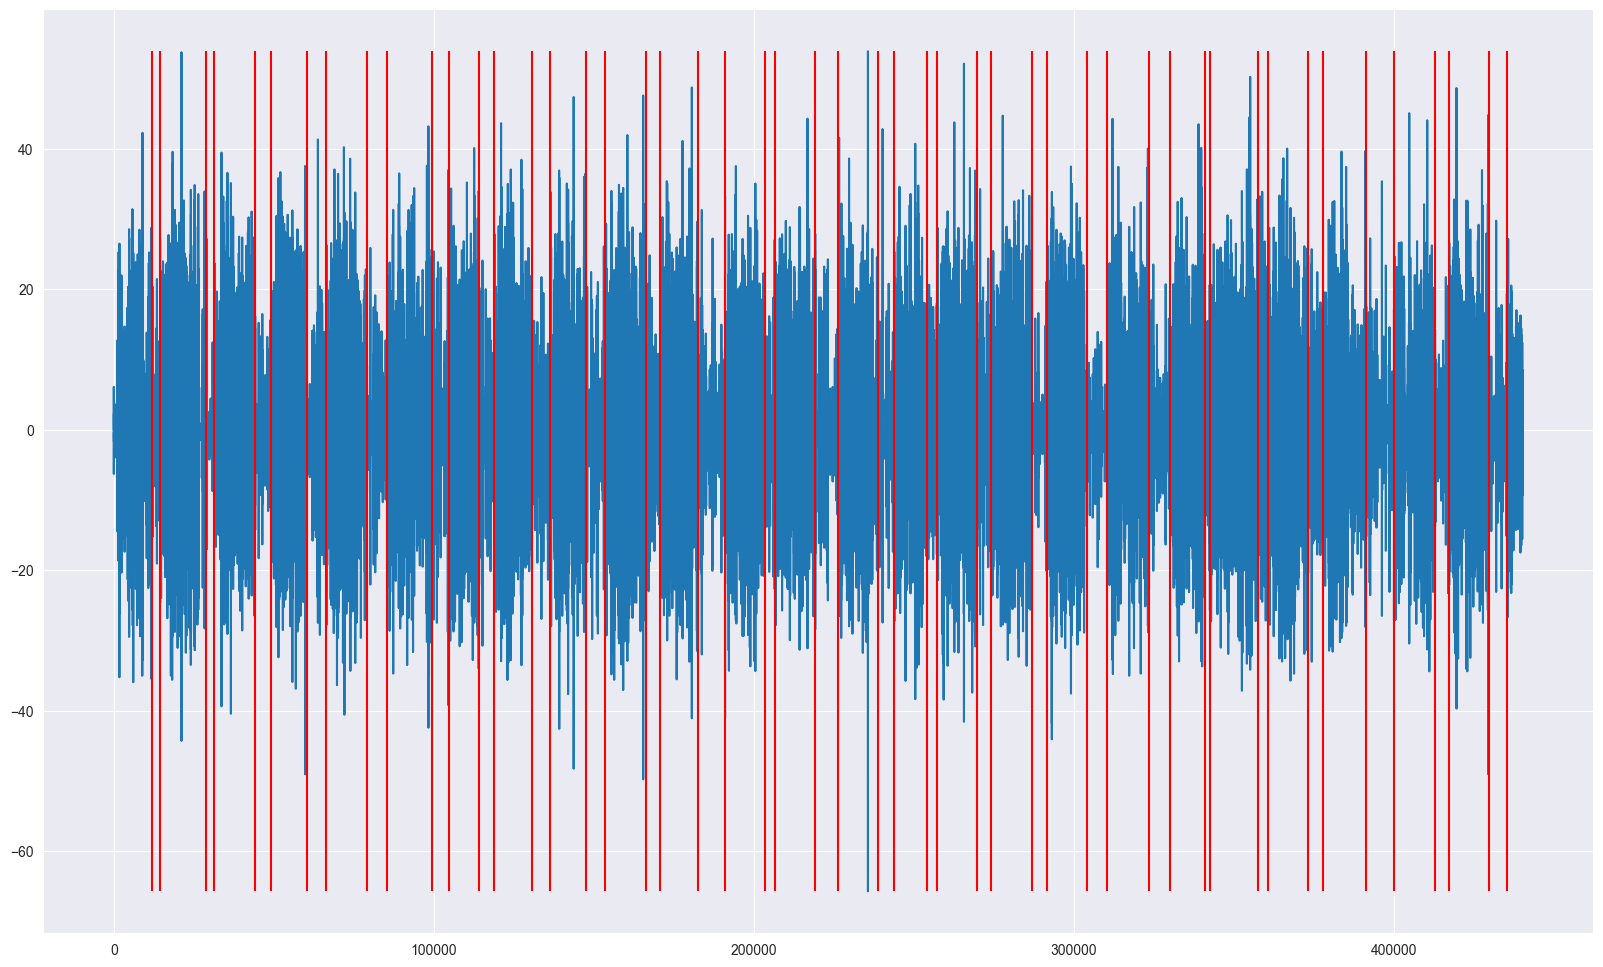

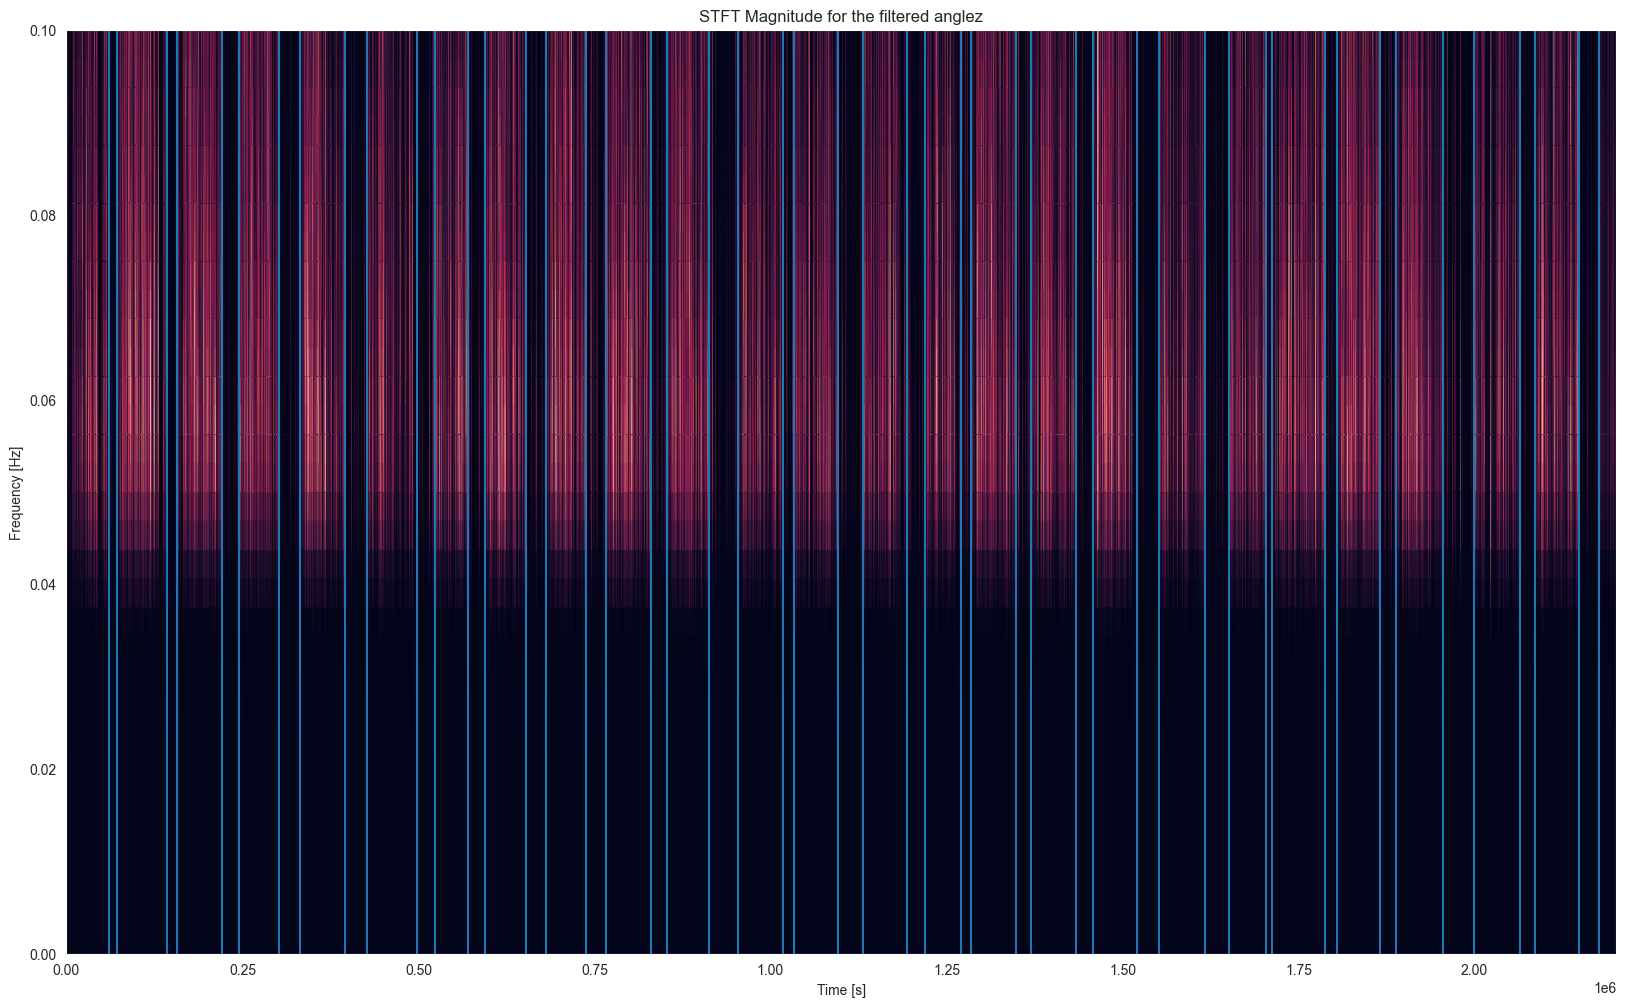

###  enmo for series 08db4255286f

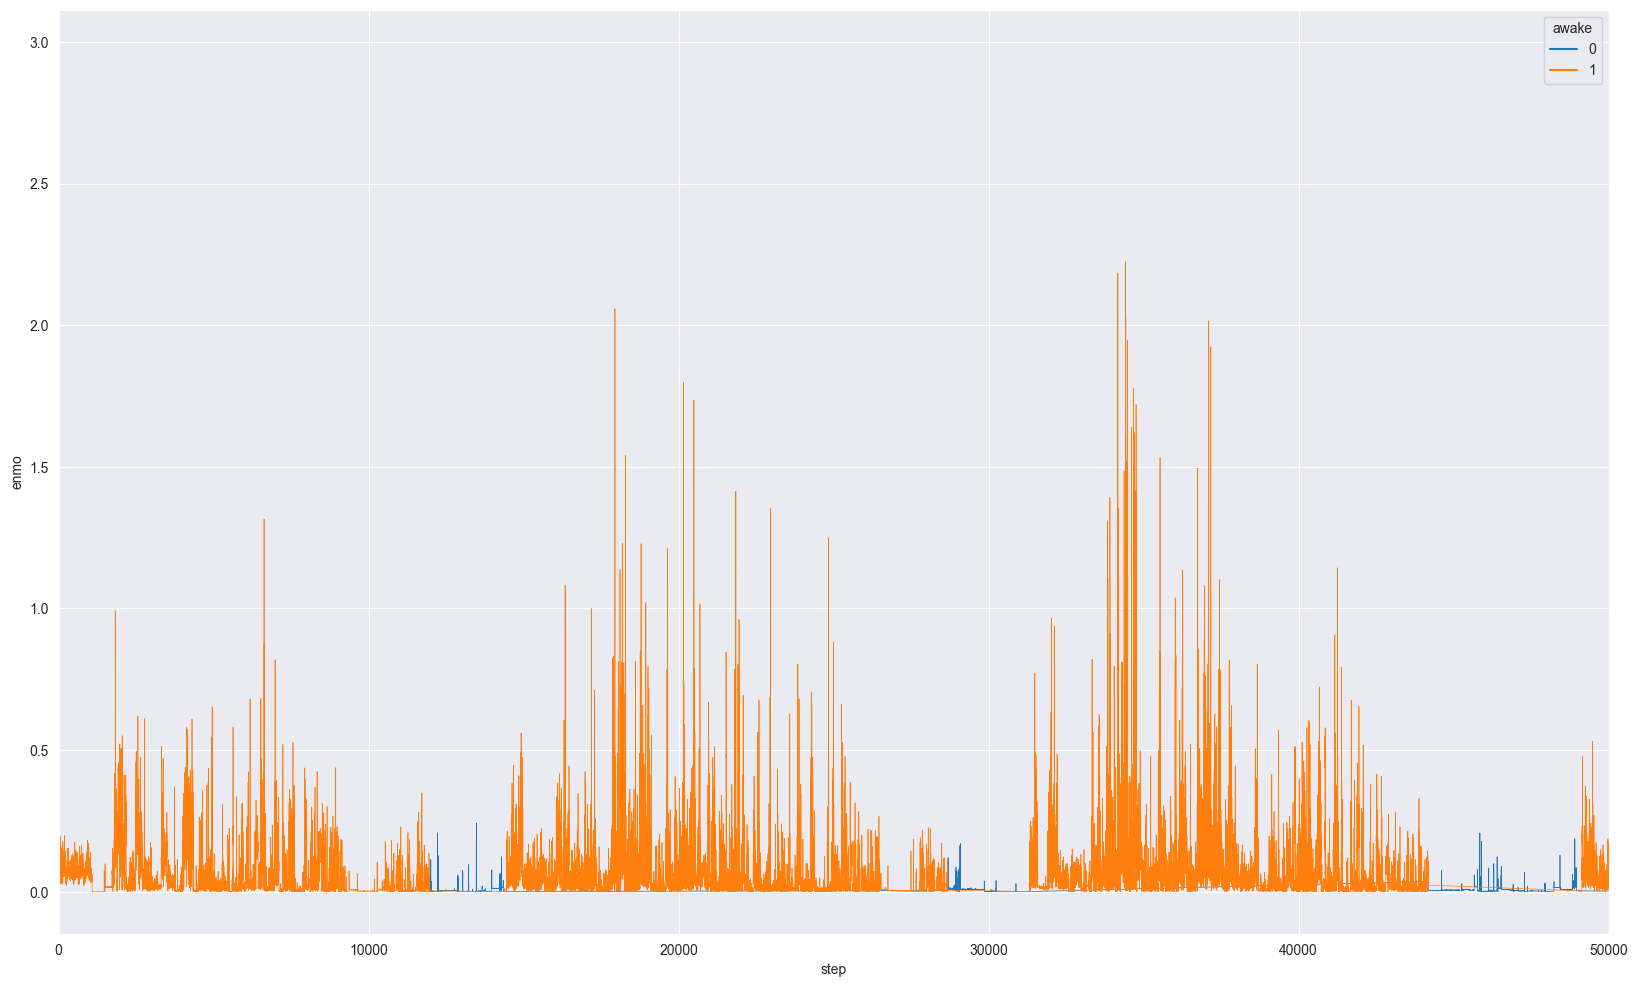

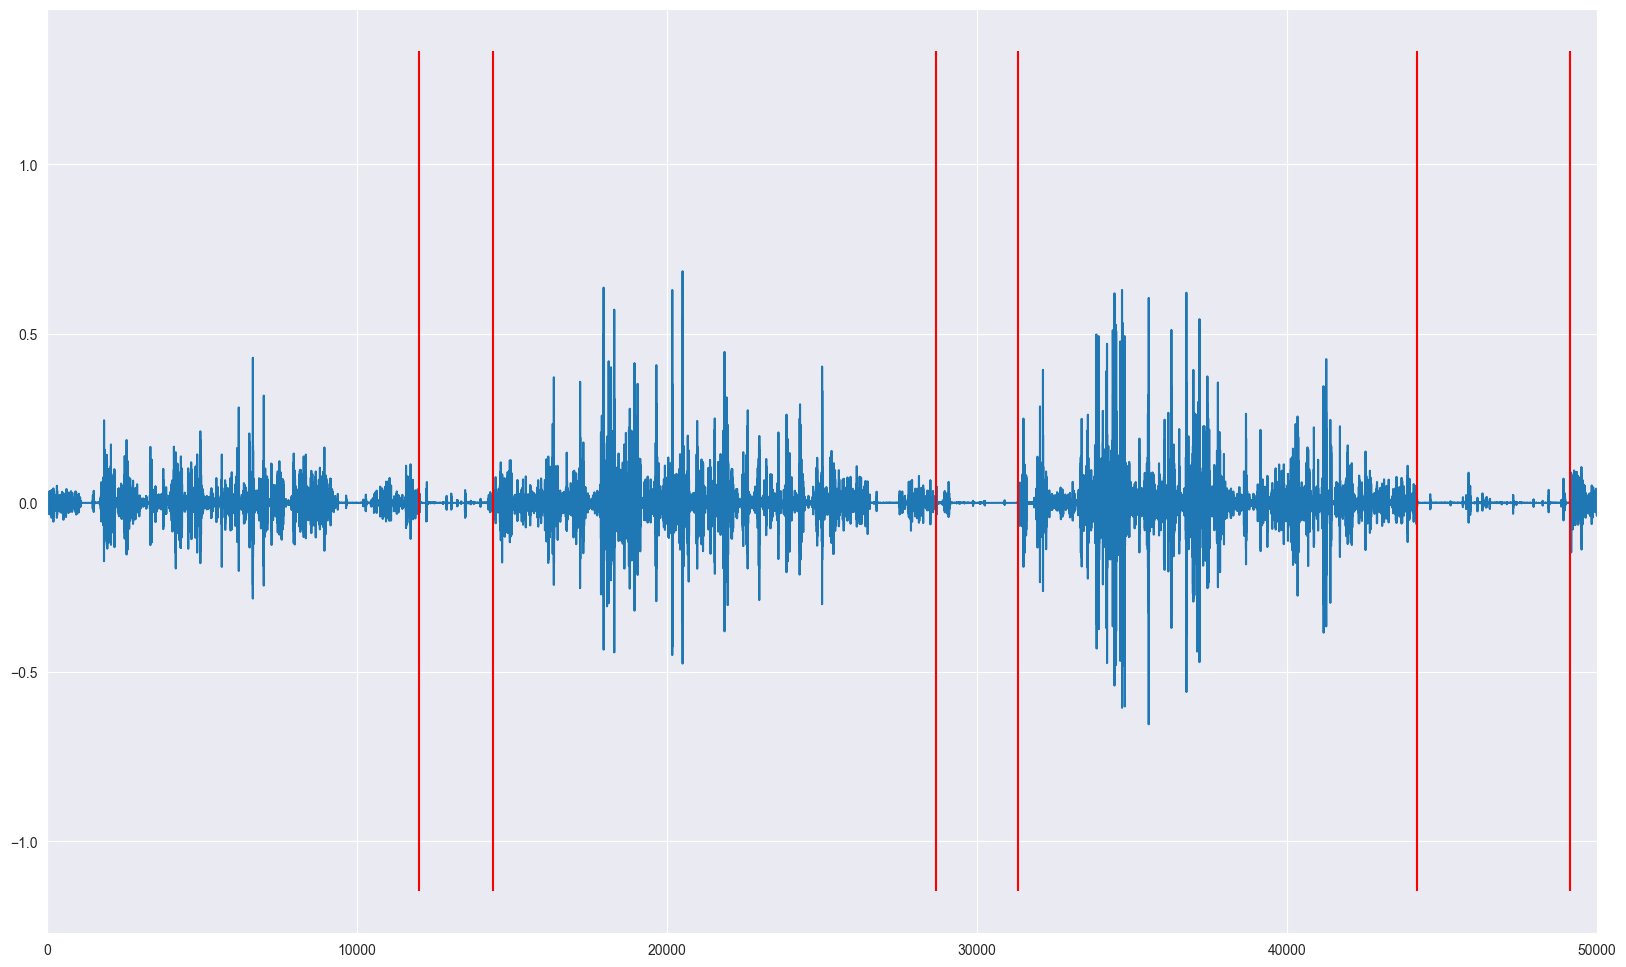

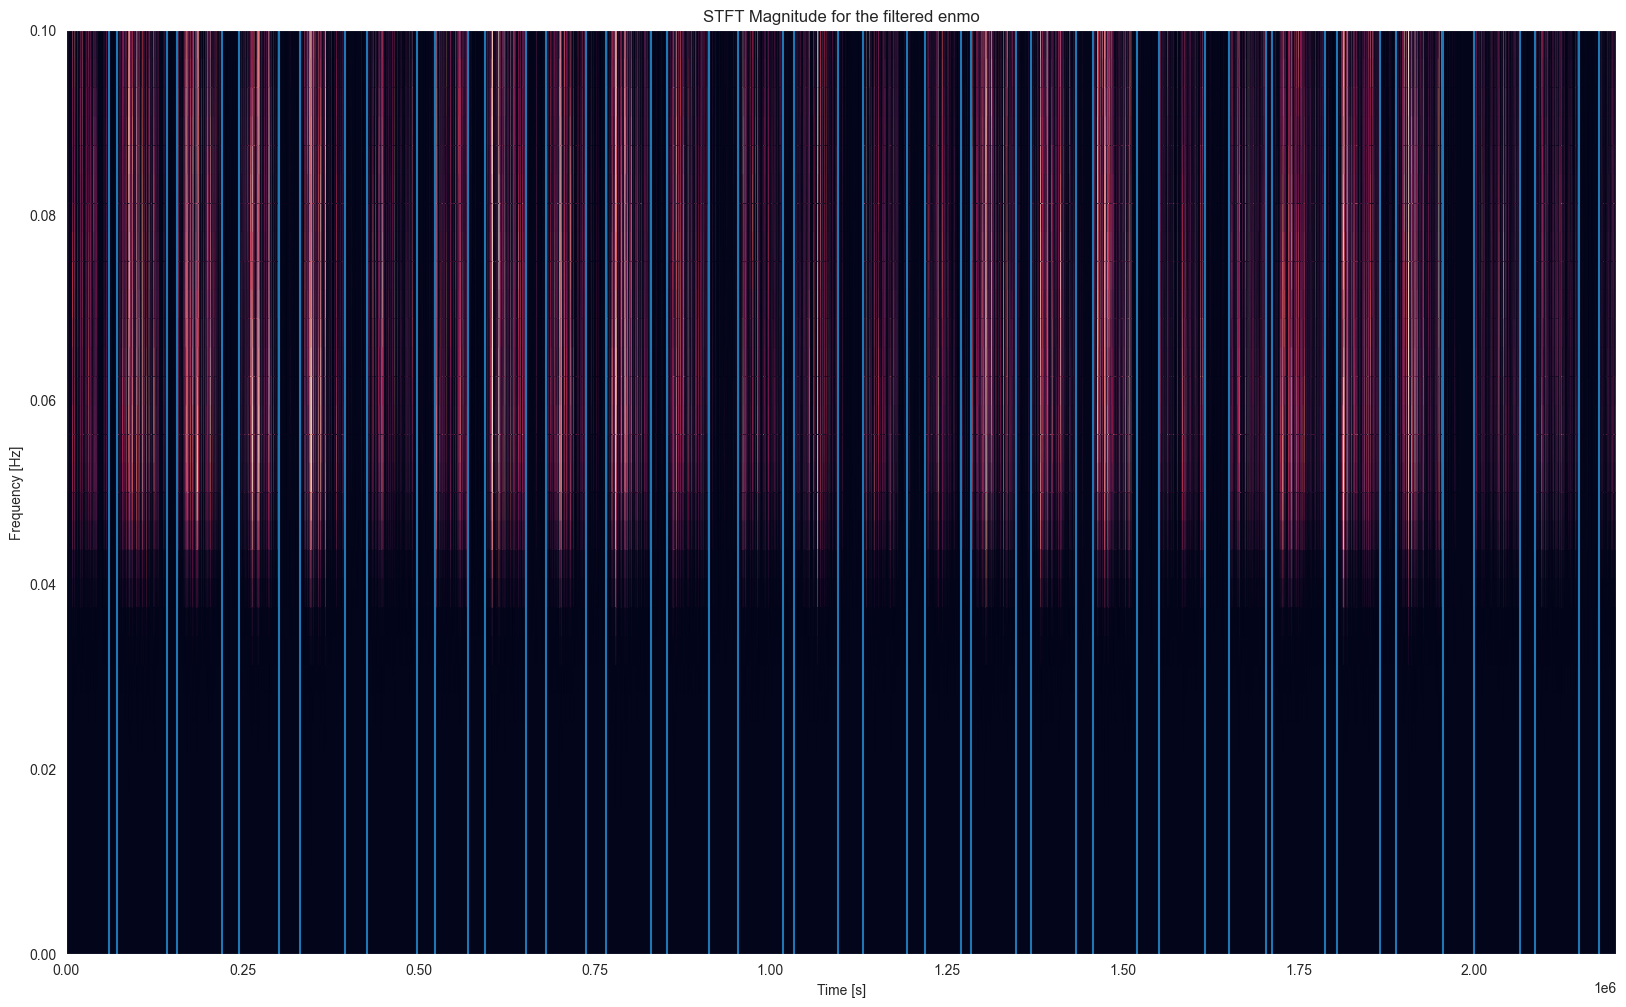

In [8]:
# now going to apply a high pas filter to the sequence
# from the spectograms looks like for both cases the awake state has higher frequencies than sleeping (to be expected)

# for anglez not so much but for the enmo the amplitude also is much higher compared to being asleep


sos = signal.butter(10,0.05, 'highpass', analog = False, fs = 0.2, output = 'sos')


for series_id in notNaN[:1]:
    train = get_train_series(train_series, train_events, series_id)
    print(train.dtypes)
    clean_train_data.append(train)

    # get the indices of when a state transition occurs to visualize in the stft plots
    #display(train['awake'])
    diffs = np.diff(train['awake'])
    idxs = np.where(np.abs(diffs) == 1)
    print(np.shape(idxs))
    # the timestamps are 5 seconds per step
    timestamps = np.multiply(idxs, [5])
    # separate the anglez and enmo values for later
    anglez = train['anglez']
    enmo = train['enmo']
    # use stft from scipy to generate fft over time curve
    # Important: To be able to use fft and stft we need to know the sampling freq.
    # ie. frequency at which our data was collected. Since we get 1 sample every 5 seconds our
    # Fs = 0.2 Hz
    fs = 0.2

    # visualize anglez over steps
    display(Markdown('###  anglez for series ' + series_id))
    plt.figure(figsize=(20, 12))
    sns.lineplot(data=train, x="step", y="anglez",hue="awake", linewidth = 0.5)
    plt.show()

    # now apply the high pass filter to the anglez data
    filtered_anglez = signal.sosfilt(sos, anglez)

    # now do stft on the filtered signal to see if the results differ
    plt.figure(figsize=(20, 12))
    plt.plot(filtered_anglez)
    plt.vlines(timestamps/5, ymin = min(filtered_anglez), ymax = max(filtered_anglez), colors = 'r')
    plt.show()

    f, t, Zxx = signal.stft(filtered_anglez, fs, nperseg=32, scaling = 'psd')
    Y_abs = np.abs(Zxx)

    #plot the stft results for the filtered anglez
    plt.figure(figsize=(20, 12))
    #Set the max scale of the colormesh to mean+5*std otherwise outliers make the graph unreadable
    plt.pcolormesh(t, f, np.abs(Zxx),vmax=np.mean(Y_abs)+5*np.std(Y_abs),shading='gouraud')
    plt.vlines(timestamps, ymin=0, ymax = fs/2)
    plt.title('STFT Magnitude for the filtered anglez')
    plt.ylabel('Frequency [Hz]')
    plt.xlabel('Time [s]')
    plt.show()


    # display the enmo values over time
    display(Markdown('###  enmo for series ' + series_id))
    plt.figure(figsize=(20, 12))
    sns.lineplot(data=train, x="step", y="enmo",hue="awake", linewidth = 0.5)
    plt.xlim([0,50000])
    plt.show()


    # apply the filter to enmo
    filtered_enmo = signal.sosfilt(sos, enmo)

    plt.figure(figsize=(20, 12))
    plt.plot(filtered_enmo)
    plt.xlim([0,50000])
    plt.vlines(timestamps/5, ymin = min(filtered_enmo), ymax = max(filtered_enmo), colors = 'r')
    plt.show()


    f, t, Zxx = signal.stft(filtered_enmo, fs, nperseg=32, scaling = 'psd')
    Y_abs = np.abs(Zxx)

    #plot the stft results for the filtered enmo
    plt.figure(figsize=(20, 12))
    #Set the max scale of the colormesh to mean+5*std otherwise outliers make the graph unreadable
    plt.pcolormesh(t, f, np.abs(Zxx),vmax=np.mean(Y_abs)+5*np.std(Y_abs),shading='gouraud')
    plt.vlines(timestamps, ymin=0, ymax = fs/2)
    plt.title('STFT Magnitude for the filtered enmo')
    plt.ylabel('Frequency [Hz]')
    plt.xlabel('Time [s]')
    plt.show()

    del train

series_id     object
step          uint32
timestamp     object
anglez       float32
enmo         float32
awake          int32
dtype: object
(1, 50)


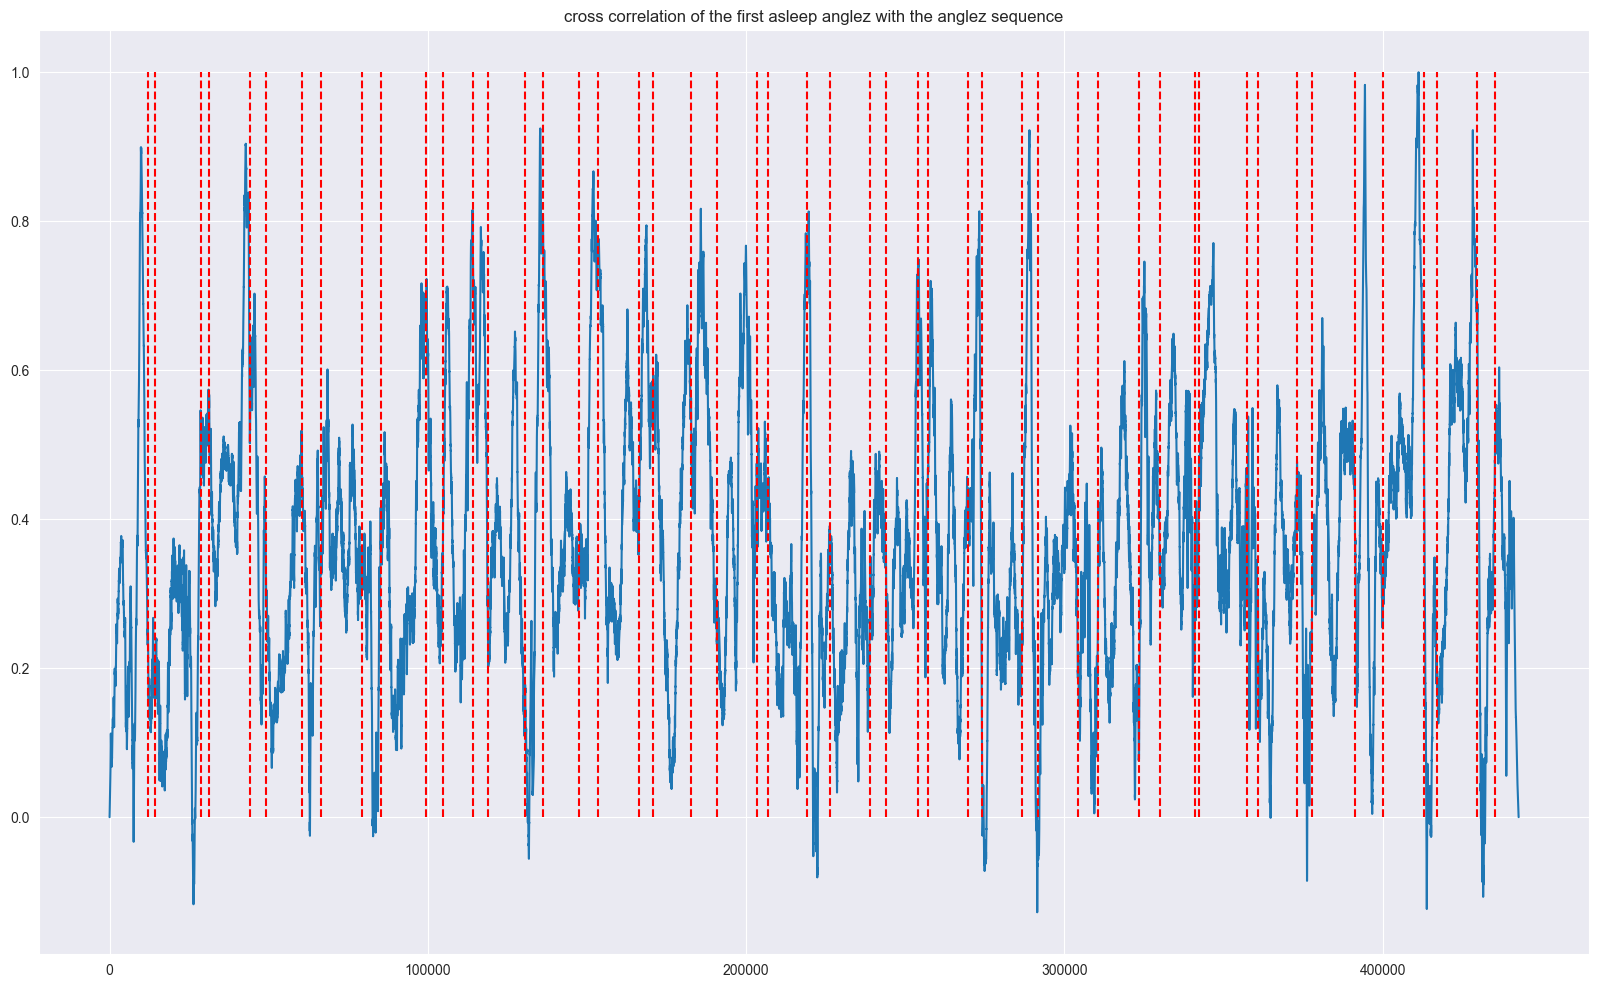

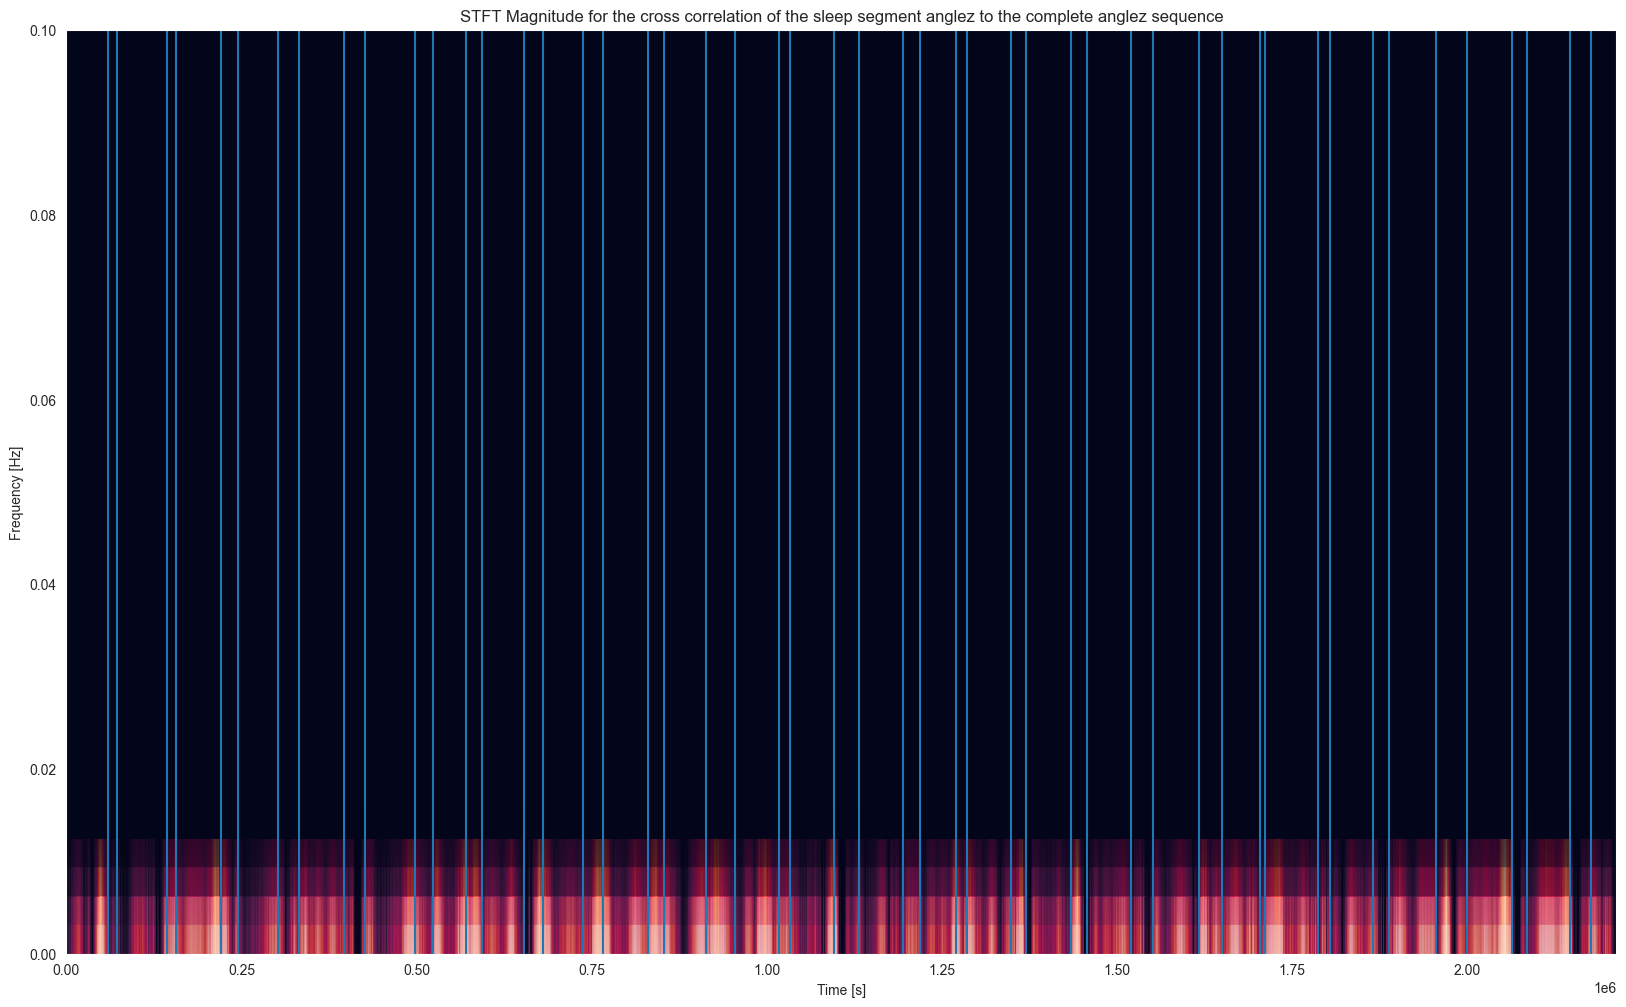

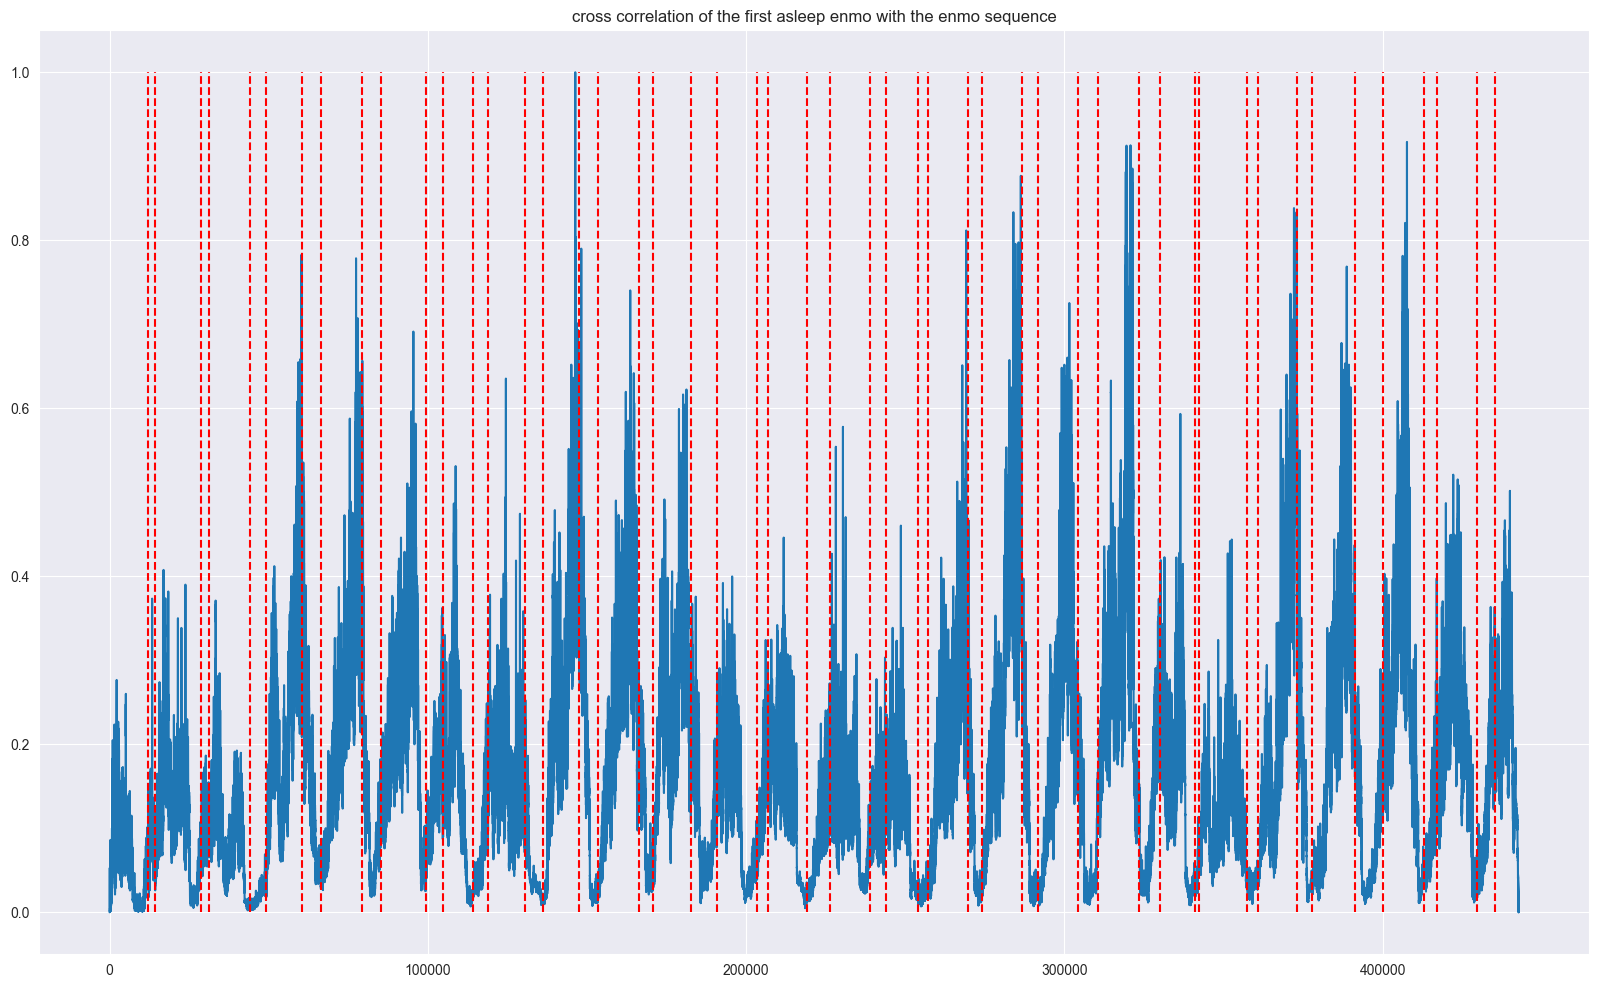

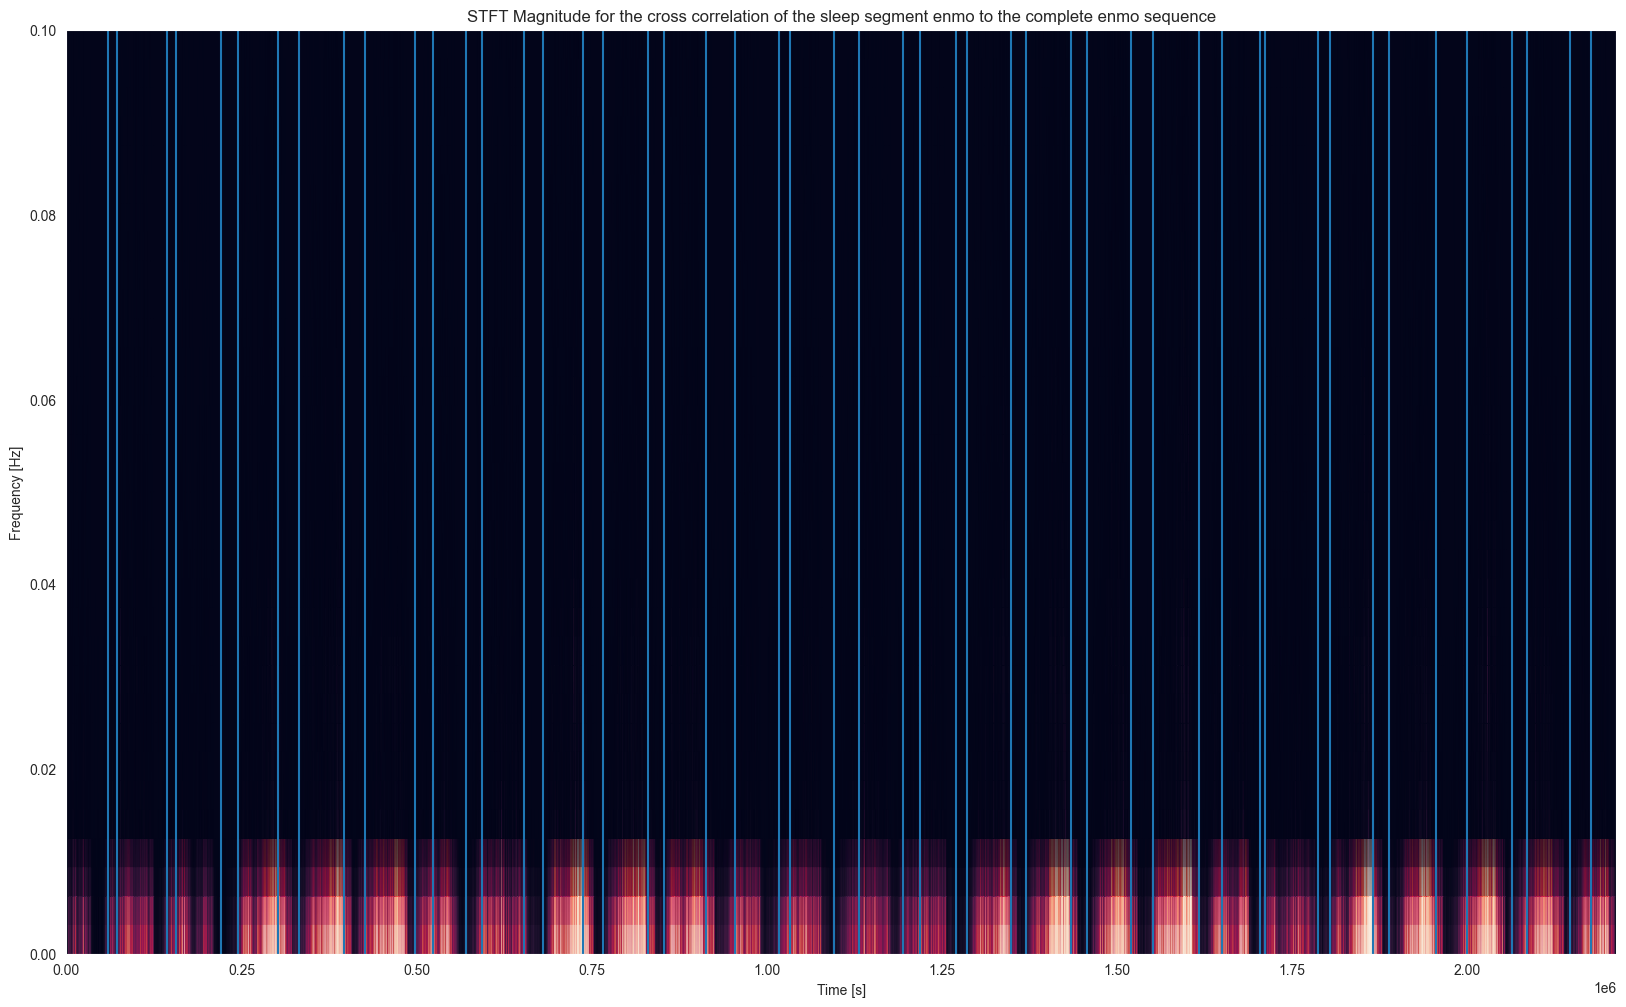

In [29]:
# Now gonna visualize the cross correlation of the anglez to enmo
# cross correlation is a mathematical measure of how correlated a sequence is with another
# it is usually used to see if 2 signals are similar.
# take only a single asleep section of one sequence
for series_id in notNaN[:1]:
    train = get_train_series(train_series, train_events, series_id)
    print(train.dtypes)
    clean_train_data.append(train)

    # get the indices of when a state transition occurs to visualize in the stft plots
    #display(train['awake'])
    diffs = np.diff(train['awake'])
    idxs = np.where(np.abs(diffs) == 1)
    print(np.shape(idxs))
    # the timestamps are 5 seconds per step
    timestamps = np.multiply(idxs, [5])
    # separate the anglez and enmo values for later
    train['anglez'] = train['anglez']
    train['enmo'] = train['enmo']
    anglez = train['anglez']
    enmo = train['enmo']

    # separate each sleep and awake section of the sequence in to a new group
    train['group'] = (train['awake'] != train['awake'].shift(1)).cumsum()
    # print(train['group'].head())
    grouped = train.groupby('group')

    # make a list with all the asleep sequences
    sleep_seqs = []
    for group_name, group_data in grouped:
        #print(f"Group {group_name}:\n{group_data[['awake']]}")
        average_value = group_data['awake'].mean()

        if average_value >= 0.5:
            group_type = 1
        else:
            group_type = 0
        if group_type == 0:
            sleep_seqs.append(group_data)

    # this is the first sleep sequence of this series
    # print(sleep_seq.head())
    sleep_anglez = sleep_seqs[0]['anglez']
    sleep_enmo = sleep_seqs[0]['enmo']

    # apply the sosfilter from before to the sequences
    # dont do this shit results
    # sleep_anglez = signal.sosfilt(sos,sleep_anglez)
    # sleep_enmo = signal.sosfilt(sos,sleep_enmo)

    # now computing the cross correlation of it with the original series_id
    corr = signal.correlate(sleep_anglez, anglez, mode='full')
    corr /= np.max(corr)
    plt.figure(figsize=(20,12))
    plt.plot(corr)
    plt.title('cross correlation of the first asleep anglez with the anglez sequence')
    plt.vlines(timestamps/5, colors = 'r', ymin = 0, ymax = 1, linestyle = 'dashed')
    plt.show()

    fs = 0.2
    f, t, Zxx = signal.stft(corr, fs, nperseg=32, scaling = 'psd')
    Y_abs = np.abs(Zxx)

    #plot the stft results for the filtered enmo
    plt.figure(figsize=(20, 12))
    #Set the max scale of the colormesh to mean+5*std otherwise outliers make the graph unreadable
    plt.pcolormesh(t, f, np.abs(Zxx),vmax=np.mean(Y_abs)+5*np.std(Y_abs),shading='gouraud')
    plt.vlines(timestamps, ymin=0, ymax = fs/2)
    plt.title('STFT Magnitude for the cross correlation of the sleep segment anglez to the complete anglez sequence')
    plt.ylabel('Frequency [Hz]')
    plt.xlabel('Time [s]')
    plt.show()

    corr = signal.correlate(sleep_enmo, enmo, mode='full')
    corr /= np.max(corr)
    plt.figure(figsize=(20,12))
    plt.plot(corr)
    plt.title('cross correlation of the first asleep enmo with the enmo sequence')
    plt.vlines(timestamps/5, colors = 'r', ymin = 0, ymax = 1, linestyle = 'dashed')
    plt.show()

    fs = 0.2
    f, t, Zxx = signal.stft(corr, fs, nperseg=32, scaling = 'psd')
    Y_abs = np.abs(Zxx)

    #plot the stft results for the filtered enmo
    plt.figure(figsize=(20, 12))
    #Set the max scale of the colormesh to mean+5*std otherwise outliers make the graph unreadable
    plt.pcolormesh(t, f, np.abs(Zxx),vmax=np.mean(Y_abs)+5*np.std(Y_abs),shading='gouraud')
    plt.vlines(timestamps, ymin=0, ymax = fs/2)
    plt.title('STFT Magnitude for the cross correlation of the sleep segment enmo to the complete enmo sequence')
    plt.ylabel('Frequency [Hz]')
    plt.xlabel('Time [s]')
    plt.show()

    # IMPORTANT if we want to make this thing work we would need a singular universal section for being asleep
    # Averaging does not really help because the shapes of the sections are not really consistent and the average per sequence doesnt rly apply to the test dataset


    # now to see what the spectogram of the cross correlations


In [10]:
# Now I integrate the sequence and visualize what it looks like
# integral doesnt give anything meaningfull sadly
# from scipy import integrate
# for series_id in notNaN[:1]:
#     train = get_train_series(train_series, train_events, series_id)
#     print(train.dtypes)
#     clean_train_data.append(train)
#
#     # get the indices of when a state transition occurs to visualize in the stft plots
#     #display(train['awake'])
#     diffs = np.diff(train['awake'])
#     idxs = np.where(np.abs(diffs) == 1)
#     print(np.shape(idxs))
#     # the timestamps are 5 seconds per step
#     timestamps = np.multiply(idxs, [5])
#     # separate the anglez and enmo values for later
#     # train['anglez'] = train['anglez'].abs()
#     # train['enmo'] = train['enmo'].abs()
#     anglez = train['anglez'].to_numpy()
#     enmo = train['enmo'].to_numpy()
#     # integrate the sequence using cumtrapz from scipy
#     integral_enmo = integrate.cumtrapz(enmo,np.arange(0,len(enmo)), initial = 0)
#     plt.figure(figsize=(20,12))
#     plt.plot(enmo, c='b')
#     plt.plot(integral_enmo, c='r')
#     plt.vlines(timestamps/5, colors = 'g', ymin = 0, ymax = np.max(integral_enmo), linestyle = 'dashed')
#     plt.legend(['enmo', 'integral enmo', 'state changes'])
#     plt.show()
#
#     integral_anglez = integrate.cumtrapz(anglez,np.arange(0,len(anglez)), initial = 0)
#     plt.figure(figsize=(20,12))
#     plt.plot(anglez, c='b')
#     plt.plot(integral_anglez, c='r')
#     plt.vlines(timestamps/5, colors = 'g', ymin = np.min(integral_anglez), ymax = np.max(integral_anglez), linestyle = 'dashed')
#     plt.legend(['anglez', 'integral anglez', 'state changes'])
#     plt.show()
#


In [11]:
# now look at the gradient
# also not very promising
# for series_id in notNaN[:1]:
#     train = get_train_series(train_series, train_events, series_id)
#     print(train.dtypes)
#     clean_train_data.append(train)
#
#     # get the indices of when a state transition occurs to visualize in the stft plots
#     #display(train['awake'])
#     diffs = np.diff(train['awake'])
#     idxs = np.where(np.abs(diffs) == 1)
#     print(np.shape(idxs))
#     # the timestamps are 5 seconds per step
#     timestamps = np.multiply(idxs, [5])
#     # separate the anglez and enmo values for later
#     # train['anglez'] = train['anglez'].abs()
#     # train['enmo'] = train['enmo'].abs()
#     anglez = train['anglez'].to_numpy()
#     enmo = train['enmo'].to_numpy()
#     # integrate the sequence using cumtrapz from scipy
#     grad_enmo = np.gradient(enmo)
#     plt.figure(figsize=(20,12))
#     plt.plot(enmo, c='b')
#     plt.plot(grad_enmo, c='r')
#     plt.vlines(timestamps/5, colors = 'g', ymin = 0, ymax = np.max(enmo), linestyle = 'dashed')
#     plt.legend(['enmo', 'grad enmo', 'state changes'])
#     plt.show()
#
#     grad_anglez = np.gradient(anglez)
#     plt.figure(figsize=(20,12))
#     plt.plot(anglez, c='b')
#     plt.plot(grad_anglez, c='r')
#     plt.vlines(timestamps/5, colors = 'g', ymin = 0, ymax = np.max(anglez), linestyle = 'dashed')
#     plt.legend(['anglez', 'grad anglez', 'state changes'])
#     plt.show()
